=== BEFORE CLEANING ===
Shape: (541909, 8)
Duplicates: 5268

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Average Purchases per Customer: 5.07548032936871

Canceled Transactions (start with 'C'): 0


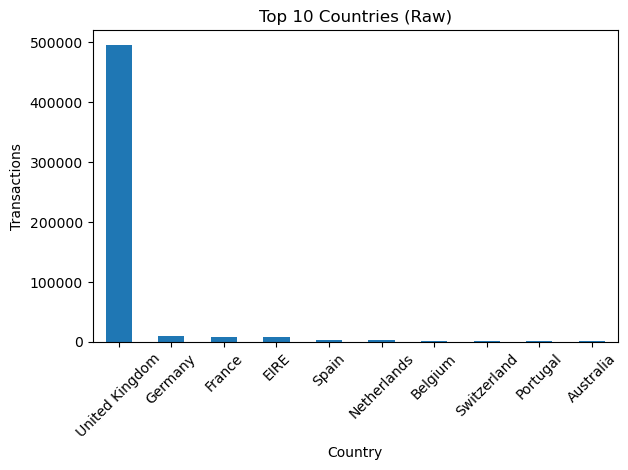

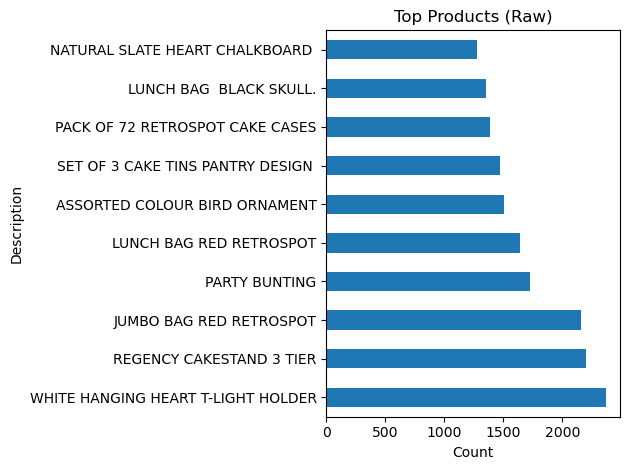

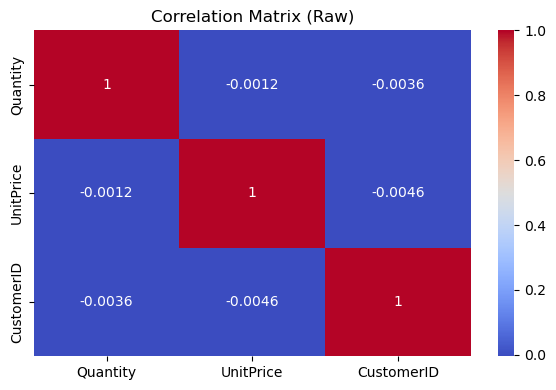

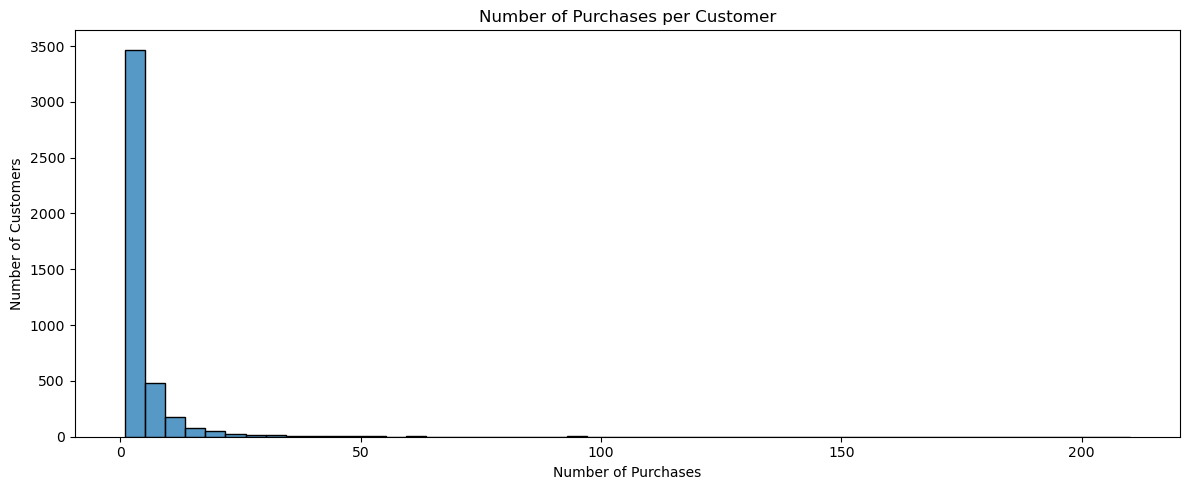

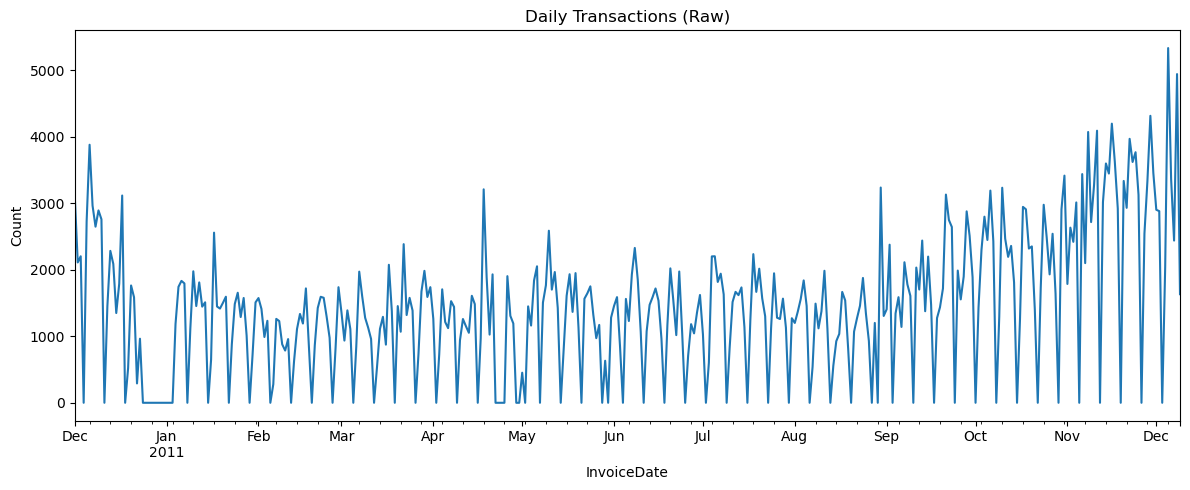


=== AFTER DROPPING DUPLICATES ===
Shape: (536641, 8)
Duplicates: 0

=== AFTER DROPPING MISSING VALUES ===
Missing Values:
 InvoiceDate    0
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

=== FINAL SHAPE AFTER REMOVING CANCELED INVOICES ===
Shape: (392732, 8)

Average Purchases per Customer (Cleaned): 4.271952062687255


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data (Before Cleaning) ---
file_path = r"C:\Users\adnan\Downloads\archive (3)\Online-Retail.xlsx"
df_raw = pd.read_excel(file_path, sheet_name='Online Retail')

# --- Initial Insights ---
print("=== BEFORE CLEANING ===")
print("Shape:", df_raw.shape)
print("Duplicates:", df_raw.duplicated().sum())
print("\nMissing Values:\n", df_raw.isnull().sum())
print("\nAverage Purchases per Customer:",
      df_raw.groupby('CustomerID')['InvoiceNo'].nunique().mean())

canceled_count = df_cleaned['InvoiceNo'].astype(str).str.startswith('C').sum()
print(f"\nCanceled Transactions (start with 'C'): {canceled_count}")

# --- EDA Visuals Before Cleaning ---
# Top Countries
df_raw['Country'].value_counts().head(10).plot(kind='bar', title="Top 10 Countries (Raw)")
plt.ylabel("Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top Products
df_raw['Description'].value_counts().head(10).plot(kind='barh', title="Top Products (Raw)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(df_raw.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Raw)")
plt.tight_layout()
plt.show()

# --- Plot: Number of Purchases per Customer ---
purchase_counts = df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.histplot(purchase_counts, bins=50, kde=False)
plt.title("Number of Purchases per Customer")
plt.xlabel("Number of Purchases")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.savefig("purchases_per_customer.pdf")
plt.show()


# Transactions Over Time
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'], errors='coerce')
df_raw.set_index('InvoiceDate', inplace=True)
df_raw.resample('D').size().plot(title="Daily Transactions (Raw)", figsize=(12, 5))
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("transactions_over_time.pdf")
plt.show()

# --- Clean Data ---
df_cleaned = df_raw.reset_index()
df_cleaned = df_cleaned.drop_duplicates()
print("\n=== AFTER DROPPING DUPLICATES ===")
print("Shape:", df_cleaned.shape)
print("Duplicates:", df_cleaned.duplicated().sum())

df_cleaned = df_cleaned.dropna()
print("\n=== AFTER DROPPING MISSING VALUES ===")
print("Missing Values:\n", df_cleaned.isnull().sum())

df_cleaned = df_cleaned[~df_cleaned['InvoiceNo'].astype(str).str.startswith('C')]
print("\n=== FINAL SHAPE AFTER REMOVING CANCELED INVOICES ===")
print("Shape:", df_cleaned.shape)

# --- Average Purchases per Customer After Cleaning ---
print("\nAverage Purchases per Customer (Cleaned):",
      df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique().mean())


In [18]:
# Combined CLV Modeling Code with Linear Regression, Random Forest, XGBoost, and RF (RFM only)

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from xgboost import XGBRegressor

# Shared time periods
hist_end = datetime(2011, 9, 1)
hold_end = datetime(2011, 12, 9)
RANDOM_SEED = 42

############################
# Linear Regression Model #
############################

hist = df[df["InvoiceDate"] < hist_end].copy()
hold = df[(df["InvoiceDate"] >= hist_end) & (df["InvoiceDate"] < hold_end)].copy()
hist["Revenue"] = hist["Quantity"] * hist["UnitPrice"]

orders = hist.groupby(["CustomerID", "InvoiceNo"]).agg(
    InvoiceDate=("InvoiceDate", "min"),
    Revenue=("Revenue", "sum"),
    Quantity=("Quantity", "sum"),
    StockCode=("StockCode", "nunique")
).reset_index()

cust = orders.groupby("CustomerID").agg(
    FirstPurchase=("InvoiceDate", "min"),
    LastPurchase=("InvoiceDate", "max"),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Revenue", "sum"),
    UniqueProducts=("StockCode", "sum")
).assign(
    Recency=lambda d: (hist_end - d.LastPurchase).dt.days,
    Tenure=lambda d: (hist_end - d.FirstPurchase).dt.days
)

rev_std = orders.groupby("CustomerID")["Revenue"].std().fillna(0.0).rename("RevenueStdDev")

clv = hold.assign(Revenue=hold["Quantity"] * hold["UnitPrice"]).groupby("CustomerID")["Revenue"].sum().rename("CLV")

monetary_3m = hist[(hist["InvoiceDate"] >= datetime(2011, 6, 1)) & (hist["InvoiceDate"] < hist_end)]
monetary_3m = monetary_3m.assign(Revenue=monetary_3m["Quantity"] * monetary_3m["UnitPrice"])
monetary_3m = monetary_3m.groupby("CustomerID")["Revenue"].sum().rename("MonetaryLast3M")

features = cust.merge(rev_std, left_index=True, right_index=True, how="left")
features = features.merge(clv, left_index=True, right_index=True, how="left")
features = features.merge(monetary_3m, left_index=True, right_index=True, how="left")
features = features.fillna({"RevenueStdDev": 0.0, "CLV": 0.0, "MonetaryLast3M": 0.0})

X_lr = features.drop(columns=["CLV", "FirstPurchase", "LastPurchase"]).select_dtypes(include=[np.number])
y_lr = features["CLV"].values

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.30, random_state=RANDOM_SEED)

lr = LinearRegression()
cv_lr = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
mae_scores_lr = -cross_val_score(lr, X_train_lr, y_train_lr, cv=cv_lr, scoring="neg_mean_absolute_error")
print(f"Mean CV MAE (Linear Regression): {mae_scores_lr.mean():.2f}")

lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)
print("\nTest Set Performance (Linear Regression)")
print(f"  MAE:  {mean_absolute_error(y_test_lr, y_pred_lr):.2f}")

##########################
# Random Forest (Tenure) #
##########################

X_rf = X_lr.copy()
y_rf = y_lr.copy()
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.30, random_state=RANDOM_SEED)

rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
param_dist_rf = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 5, 7, 9],
    "criterion": ["absolute_error"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3]
}

cv_rf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
rand_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, n_iter=40, scoring="neg_mean_absolute_error",
    cv=cv_rf, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rand_search_rf.fit(X_train_rf, y_train_rf)
best_rf = rand_search_rf.best_estimator_
print("\nBest hyperparameters (RF):", rand_search_rf.best_params_)
print(f"Best CV MAE: {-rand_search_rf.best_score_:.2f}")
y_pred_rf = best_rf.predict(X_test_rf)
print("\nTest Set Performance (Tuned RF)")
print(f"  MAE:  {mean_absolute_error(y_test_rf, y_pred_rf):.2f}")

#################
# XGBoost Model #
#################

X_xgb = X_lr.copy()
y_xgb = y_lr.copy()
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.30, random_state=RANDOM_SEED)

xgb = XGBRegressor(objective='reg:absoluteerror', eval_metric='mae', random_state=RANDOM_SEED, n_jobs=-1)
param_dist_xgb = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 3, 5]
}

cv_xgb = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
rand_search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist_xgb, n_iter=40, scoring="neg_mean_absolute_error",
    cv=cv_xgb, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rand_search_xgb.fit(X_train_xgb, y_train_xgb)
best_xgb = rand_search_xgb.best_estimator_
print("\nBest hyperparameters (XGB):", rand_search_xgb.best_params_)
print(f"Best CV MAE: {-rand_search_xgb.best_score_:.2f}")
y_pred_xgb = best_xgb.predict(X_test_xgb)
print("\nTest Set Performance (Tuned XGBoost)")
print(f"  MAE:  {mean_absolute_error(y_test_xgb, y_pred_xgb):.2f}")

###########################
# Random Forest (RFM only)
###########################

orders_rfm = hist.groupby(["CustomerID", "InvoiceNo"]).agg(InvoiceDate=("InvoiceDate", "min"), Revenue=("Revenue", "sum")).reset_index()
cust_rfm = orders_rfm.groupby("CustomerID").agg(
    FirstPurchase=("InvoiceDate", "min"),
    LastPurchase=("InvoiceDate", "max"),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Revenue", "sum")
).assign(Recency=lambda d: (hist_end - d.LastPurchase).dt.days).reset_index()

clv_rfm = hold.assign(Revenue=hold["Quantity"] * hold["UnitPrice"]).groupby("CustomerID")["Revenue"].sum().rename("CLV").reset_index()
data_rfm = cust_rfm.merge(clv_rfm, on="CustomerID", how="left").fillna({"CLV": 0.0})

X_rfm = data_rfm[["Recency", "Frequency", "Monetary"]].values
y_rfm = data_rfm["CLV"].values
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.30, random_state=RANDOM_SEED)

rf_rfm = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
rand_search_rfm = RandomizedSearchCV(
    rf_rfm, param_distributions=param_dist_rf, n_iter=40, scoring="neg_mean_absolute_error",
    cv=cv_rf, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rand_search_rfm.fit(X_train_rfm, y_train_rfm)
best_rfm = rand_search_rfm.best_estimator_
print("\nBest hyperparameters (RF RFM):", rand_search_rfm.best_params_)
print(f"Best CV MAE: {-rand_search_rfm.best_score_:.2f}")
y_pred_rfm = best_rfm.predict(X_test_rfm)
print("\nTest Set Performance (Tuned RF with RFM features)")
print(f"  MAE:  {mean_absolute_error(y_test_rfm, y_pred_rfm):.2f}")


Mean CV MAE (Linear Regression): 591.15

Test Set Performance (Linear Regression)
  MAE:  721.38
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best hyperparameters (RF): {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'absolute_error'}
Best CV MAE: 559.79

Test Set Performance (Tuned RF)
  MAE:  647.63
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best hyperparameters (XGB): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 1.0}
Best CV MAE: 558.78

Test Set Performance (Tuned XGBoost)
  MAE:  657.85
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best hyperparameters (RF RFM): {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'absolute_error'}
Best CV MAE: 557.75

Test Set Performance (Tuned RF with RFM features)

 96%|=================== | 559/583 [00:14<00:00]       

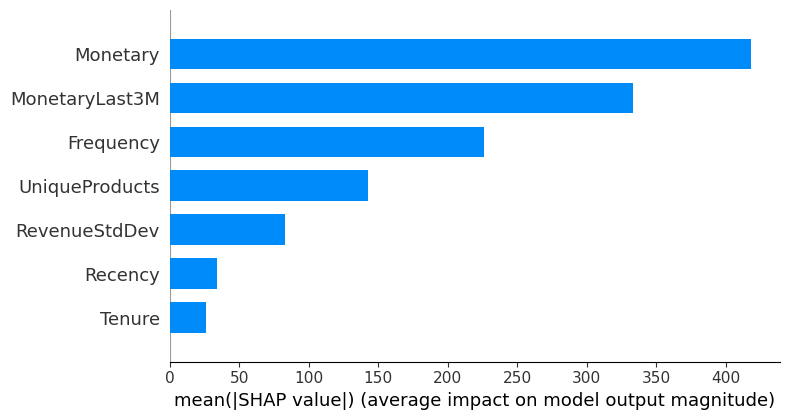


SHAP Feature Impact Table:
       Feature  Mean |SHAP Value|
      Monetary         418.029047
MonetaryLast3M         333.569884
     Frequency         225.838145
UniqueProducts         142.489351
 RevenueStdDev          83.051852
       Recency          34.263452
        Tenure          25.981410


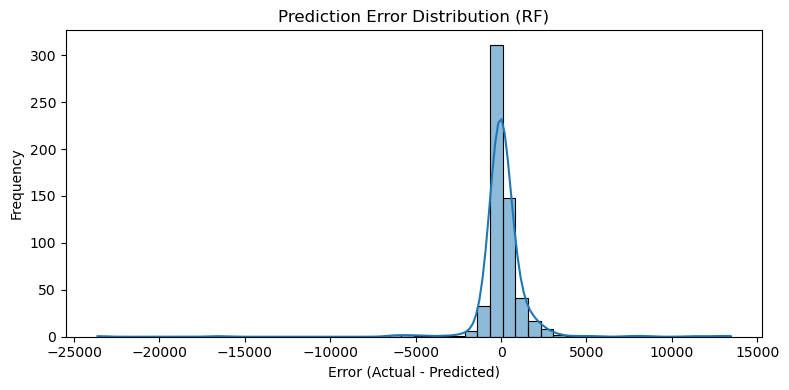

C:\Users\adnan\AppData\Local\Temp\ipykernel_20688\2656147234.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_by_decile = df_error.groupby('Decile').apply(


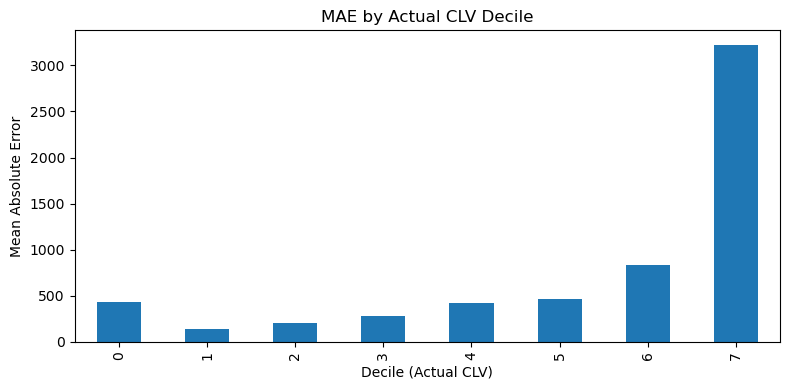

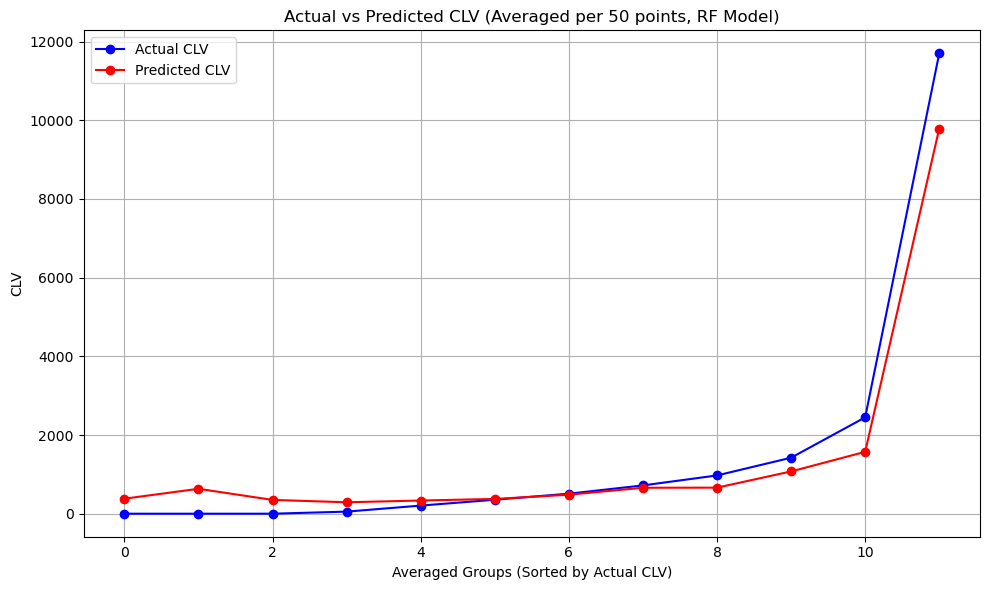

In [60]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- SHAP Analysis (bar plot + feature impact table) ---
explainer = shap.Explainer(best_rf, X_test_rf)
shap_values = explainer(X_test_rf)

# SHAP bar summary plot (save to PDF)
plt.figure()
shap.summary_plot(shap_values, X_test_rf, plot_type="bar", show=False)
plt.savefig("shap_summary_bar.pdf", bbox_inches="tight")
plt.show()
plt.close()

# SHAP feature impact table
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_impact_df = pd.DataFrame({
    'Feature': X_test_rf.columns,
    'Mean |SHAP Value|': mean_abs_shap
}).sort_values(by='Mean |SHAP Value|', ascending=False)
print("\nSHAP Feature Impact Table:")
print(shap_impact_df.to_string(index=False))

# --- Error Analysis: Histogram of residuals ---
errors = y_test_rf - y_pred_rf
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution (RF)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("prediction_error_distribution.pdf")
plt.show()



# --- MAE by Actual CLV Decile ---
df_error = pd.DataFrame({'Actual': y_test_rf, 'Predicted': y_pred_rf})
df_error['Decile'] = pd.qcut(df_error['Actual'], 10, labels=False, duplicates='drop')
error_by_decile = df_error.groupby('Decile').apply(
    lambda d: np.mean(np.abs(d['Actual'] - d['Predicted']))
)

plt.figure(figsize=(8, 4))
error_by_decile.plot(kind='bar')
plt.title("MAE by Actual CLV Decile")
plt.xlabel("Decile (Actual CLV)")
plt.ylabel("Mean Absolute Error")
plt.tight_layout()
plt.savefig("mae_by_clv_decile.pdf")
plt.show()

# --- Averaged Actual vs Predicted CLV Plot ---
sorted_idx = np.argsort(y_test_rf)
y_actual_sorted = y_test_rf[sorted_idx]
y_pred_sorted = y_pred_rf[sorted_idx]
chunk_size = 50
y_actual_avg = [np.mean(y_actual_sorted[i:i+chunk_size]) for i in range(0, len(y_actual_sorted), chunk_size)]
y_pred_avg = [np.mean(y_pred_sorted[i:i+chunk_size]) for i in range(0, len(y_pred_sorted), chunk_size)]

plt.figure(figsize=(10, 6))
plt.plot(y_actual_avg, label="Actual CLV", marker='o', linestyle='-', color='blue')
plt.plot(y_pred_avg, label="Predicted CLV", marker='o', linestyle='-', color='red')
plt.title("Actual vs Predicted CLV (Averaged per 50 points, RF Model)")
plt.xlabel("Averaged Groups (Sorted by Actual CLV)")
plt.ylabel("CLV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted_avg.pdf")
plt.show()
